# Requirements
- python 3.6.8 (3.5 should suffice)
- pip dependancies:
    - numpy
    - scipy
    - pandas
    - matplotlib
    - sklearn
    - keras
    - tensorflow

# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
RANDOM_STATE = 17
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=RANDOM_STATE)


# Generate data
### &nbsp;&nbsp; *num_alphas*: number of alphas generated between (min_alpha) and (max_alpha) inclusive
### &nbsp;&nbsp; *samples_per_alpha*: number of samples (rows) for each alpha 
### &nbsp;&nbsp; *N* : number of random variates (number of samples drawn from yulesimon distribution)
### &nbsp;&nbsp; *M* : maximun value of random variates (length of input vectors == number of features)

In [2]:
def generate_data(num_alphas, samples_per_alpha, N, min_alpha=2.01, max_alpha=3.00, random_state=0):
    '''
    params:
        num_alphas: number of alphas generated between (min_alpha) and (max_alpha) inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        N: number of RV samples (columns) per row
    '''

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, N+1), float)

    row = 0
    for alpha in np.linspace(min_alpha, max_alpha, num=num_alphas):
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=N, random_state=random_state)
            row += 1

    #lilo
    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # create a histogram (H) from (X) rows
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale (H) rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)
    return logH, y, nbins # (nbins == M)

# Create Model

In [3]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      , activity_regularizer=l2(a_reg_lr) if a_reg else None
                      , use_bias= (not batch_normalization)
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())
    
    model.add(Activation(activation))

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        , use_bias= (not batch_normalization)
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , kernel_initializer=init
                    , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                    , activity_regularizer=l2(a_reg_lr) if a_reg else None
                    , use_bias= (not batch_normalization)
                    ))
    
    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation('linear'))

    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model

# Training

In [4]:
def train(X_train, y_train, X_val, y_val, layers=[256, 256], batch_size=32):
    model = create_model(X_train.shape[1], 
                         layers=layers, 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         #optimizer=SGD(lr=1e-3, momentum=0.9, decay=0.01), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/yulesimon_{}'.format(date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.figure(figsize=(2,2))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    print('loss:', np.min(history['loss']))
    print('val_loss:', np.min(history['val_loss']))    

# Trials

In [6]:
def trial(num_alphas, samples_per_alpha, N, layers=[256, 256], batch_size=32):
    sqrt_mse, model, history = _trial(num_alphas, samples_per_alpha, N)
    return sqrt_mse

def _trial(num_alphas, samples_per_alpha, N, layers=[256, 256], batch_size=32, verbose=True):
    if verbose:
        print('working... started at: {}'.format(datetime.now().strftime('%H:%M:%S')), end='\t')
    start = time.time()
    
    X, y, M = generate_data(num_alphas=num_alphas, samples_per_alpha=samples_per_alpha, N=N, random_state=RANDOM_STATE)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    # split train/val
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

    if ('auto' == layers or None == layers):
        # h1 = max(1, round((M+1)/2))
        # h2 = max(1, round((h1+1)/2))
        # layers = [h1, h2]
        layers = [M, M]

    # training
    model, history = train(X_train, y_train, X_val, y_val, layers)

    # predict
    y_pred = model.predict(X_test).flatten()

    # evaluate
    squared_error = np.square(y_test - y_pred)
    mse = (squared_error).mean(axis=0)

    end = time.time()
    if verbose:
        print('took: {:.2f} sec'.format(end-start))

    return np.sqrt(mse), model, history, M

## Baseline

## Change N: $2^2 -> 2^{15}$
## Plot: log10(N) vs sqrt_mse

In [7]:
%%time

RANDOM_STATE = 17
print()
print('RANDOM_STATE = {}'.format(RANDOM_STATE))
print('Processing...')
print()
x = np.array([])
y = np.array([])
for i in range(2,16):
    N = 2**i  
    sqrt_mse, m, h, M = _trial(num_alphas=100, samples_per_alpha=100, N=N, layers='auto', batch_size=32, verbose=False)
    x = np.append(x, N)
    y = np.append(y, sqrt_mse)
    print('N = {}, M = {} => sqrt(mse) = {:.3f}'.format(N, M, sqrt_mse))

RANDOM_STATE = 4
print()
print('RANDOM_STATE = {}'.format(RANDOM_STATE))
print('Processing...')
print()
x2 = np.array([])
y2 = np.array([])
for i in range(2,16):
    N = 2**i  
    sqrt_mse2, m2, h2, M2 = _trial(num_alphas=100, samples_per_alpha=100, N=N, layers='auto', batch_size=32, verbose=False)
    x2 = np.append(x2, N)
    y2 = np.append(y2, sqrt_mse2)
    print('N = {}, M = {}=> sqrt(mse) = {:.3f}'.format(N, M2, sqrt_mse2))

RANDOM_STATE = 20
print()
print('RANDOM_STATE = {}'.format(RANDOM_STATE))
print('Processing...')
print()
x3 = np.array([])
y3 = np.array([])
for i in range(2,16):
    N = 2**i  
    sqrt_mse3, m3, h3, M3 = _trial(num_alphas=100, samples_per_alpha=100, N=N, layers='auto', batch_size=32, verbose=False)
    x3 = np.append(x3, N)
    y3 = np.append(y3, sqrt_mse3)
    print('N = {}, M = {}=> sqrt(mse) = {:.3f}'.format(N, M3, sqrt_mse3))



RANDOM_STATE = 17
Processing...

N = 4, M = 1 => sqrt(mse) = 0.290
N = 8, M = 4 => sqrt(mse) = 0.267
N = 16, M = 3 => sqrt(mse) = 0.150
N = 32, M = 14 => sqrt(mse) = 0.056
N = 64, M = 11 => sqrt(mse) = 0.031
N = 128, M = 101 => sqrt(mse) = 0.020
N = 256, M = 23 => sqrt(mse) = 0.012
N = 512, M = 32 => sqrt(mse) = 0.010
N = 1024, M = 48 => sqrt(mse) = 0.014
N = 2048, M = 65 => sqrt(mse) = 0.010
N = 4096, M = 72 => sqrt(mse) = 0.011
N = 8192, M = 88 => sqrt(mse) = 0.012
N = 16384, M = 119 => sqrt(mse) = 0.007
N = 32768, M = 251 => sqrt(mse) = 0.021

RANDOM_STATE = 4
Processing...

N = 4, M = 22=> sqrt(mse) = 0.116
N = 8, M = 6=> sqrt(mse) = 0.063
N = 16, M = 6=> sqrt(mse) = 0.079
N = 32, M = 4=> sqrt(mse) = 0.114
N = 64, M = 14=> sqrt(mse) = 0.025
N = 128, M = 30=> sqrt(mse) = 0.013
N = 256, M = 14=> sqrt(mse) = 0.017
N = 512, M = 107=> sqrt(mse) = 0.007
N = 1024, M = 32=> sqrt(mse) = 0.013
N = 2048, M = 46=> sqrt(mse) = 0.008
N = 4096, M = 65=> sqrt(mse) = 0.022
N = 8192, M = 206=> sqrt

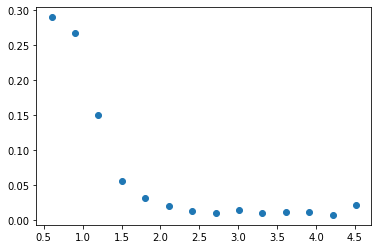

In [8]:
# plot log(N) vs sqrt_mse
_ = plt.scatter(np.log10(x), y)

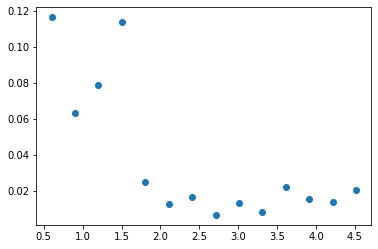

In [9]:
_ = plt.scatter(np.log10(x2), y2)

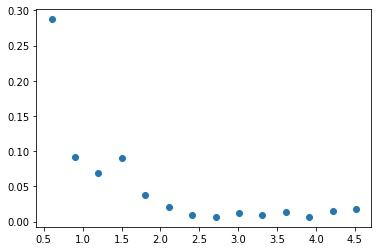

In [10]:
_ = plt.scatter(np.log10(x3), y3)

## Print learning curves and model summary

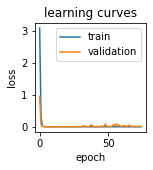

loss: 0.0034632005263119936
val_loss: 0.0005384805263020098


In [11]:
plot_learning_curves(h)

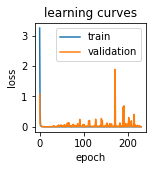

loss: 0.0029204189777374268
val_loss: 0.00044046068796887994


In [12]:
plot_learning_curves(h2)

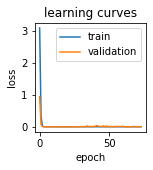

loss: 0.003486312460154295
val_loss: 0.00048301342758350074


In [14]:
plot_learning_curves(h3)

In [13]:
# model summary
m.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 251)               63001     
_________________________________________________________________
batch_normalization_39 (Batc (None, 251)               1004      
_________________________________________________________________
activation_39 (Activation)   (None, 251)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 251)               63001     
_________________________________________________________________
batch_normalization_40 (Batc (None, 251)               1004      
_________________________________________________________________
activation_40 (Activation)   (None, 251)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)               